In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix



In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau


In [3]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150
def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [4]:
train = get_training_data('../data/train')      
test = get_training_data('../data/test')
val = get_training_data('../data/val')

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_11228\771166761.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


g:\Anaconda\envs\tensorflowgpu\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
g:\Anaconda\envs\tensorflowgpu\lib\site-packages\seaborn\_core.py:1478: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


<Axes: ylabel='count'>

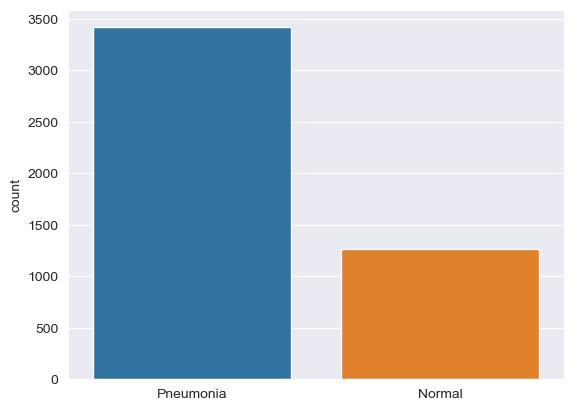

In [5]:
l = []
for i in train:
    if(i[1] == 0):
        l.append("Pneumonia")
    else:
        l.append("Normal")
sns.set_style('darkgrid')
sns.countplot(l)   

In [6]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
    
for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

In [7]:
# Normalize the data
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

In [8]:
# resize data for deep learning 
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

In [9]:
def load_augmented_data(augmented_dir, label, img_size):
    augmented_data = []
    for img in os.listdir(augmented_dir):
        try:
            img_arr = cv2.imread(os.path.join(augmented_dir, img), cv2.IMREAD_GRAYSCALE)
            resized_arr = cv2.resize(img_arr, (img_size, img_size))
            augmented_data.append([resized_arr, label])
        except Exception as e:
            print(e)
    return np.array(augmented_data)

# Define parameters
data_dir = '../data/train'  # Adjust this path to your dataset
save_dir = '../data/augmented_normal/NORMAL'  # Directory to save augmented images
label = 'NORMAL'  # Class label to augment
img_size = 150  # Image size (adjust if different)
additional_images_needed = 2690  # Number of additional images needed
batch_size = 32  # Number of images to generate per original image

# Perform augmentation
# augment_images(data_dir, save_dir, label, img_size, additional_images_needed, batch_size)

# Load augmented 'Normal' images (assuming label for 'Normal' is 1)
augmented_normal_data = load_augmented_data(save_dir, label=1, img_size=img_size)

# Convert to appropriate format and normalize
x_augmented_normal = np.array([i[0] for i in augmented_normal_data]) / 255
x_augmented_normal = x_augmented_normal.reshape(-1, img_size, img_size, 1)
y_augmented_normal = np.array([i[1] for i in augmented_normal_data])

# Append to existing training data
x_train = np.concatenate((x_train, x_augmented_normal), axis=0)
y_train = np.concatenate((y_train, y_augmented_normal), axis=0)

# Shuffle the dataset
indices = np.arange(x_train.shape[0])
np.random.shuffle(indices)
x_train = x_train[indices]
y_train = y_train[indices]

# Count after augmentation
print("Count after augmentation:", len(x_train))



C:\Users\LENOVO\AppData\Local\Temp\ipykernel_11228\411226287.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(augmented_data)


Count after augmentation: 7069


# Train All Best Models

In [10]:
# model=[[14,46,62,2,5,7],
# [29,45,88,4,4,5],
# [29,45,70,4,4,13],
# [29,45,70,4,4,13],
# [15,48,88,3,5,5],
# [15,48,88,3,5,5],
# [15,48,88,3,5,5],
# [15,48,88,3,5,5],
# [15,48,88,3,5,5],
# [15,48,88,3,5,5],
# [15,48,88,3,5,5],
# [33,47,73,4,8,20],
# [33,47,73,4,8,20],
# [35,36,75,4,6,19],
# [35,36,75,4,6,19],
# [35,36,75,4,6,19],
# [35,36,75,4,6,19],
# [35,36,75,4,6,19],
# [35,36,75,4,6,19],
# [35,36,75,4,6,19],
# [35,36,75,4,6,19],
# [35,36,75,4,6,19],
# [40,44,84,5,13,20],
# [44,36,84,4,8,18],
# [44,36,84,4,8,18],
# [44,36,84,4,8,18],
# [44,36,84,4,8,18],
# [44,36,84,4,8,18],
# [44,36,84,4,8,18],
# [45,37,85,4,10,20],
# [45,37,85,4,10,20],
# [45,37,85,4,10,20],
# [45,37,85,4,10,20],
# [45,37,85,4,10,20],
# [45,37,85,4,10,20],
# [45,37,85,4,10,20],
# [45,37,85,4,10,20],
# [45,37,85,4,10,20],
# [45,37,85,4,10,20],
# [45,37,85,4,10,20],
# [45,37,85,4,10,20],
# [45,37,85,4,10,20],
# [54,44,87,8,14,20],
# [54,41,92,6,16,20],
# [60,46,87,4,15,20],
# [58,41,97,6,14,20],
# [58,41,97,6,14,20],
# [58,41,97,6,14,20],
# [60,47,92,5,14,16],
# [60,47,92,5,14,16]]

model = [[14, 46, 62, 2, 5, 7],
 [29, 45, 88, 4, 4, 5],
 [29, 45, 70, 4, 4, 13],
 [15, 48, 88, 3, 5, 5],
 [33, 47, 73, 4, 8, 20],
 [35, 36, 75, 4, 6, 19],
 [40, 44, 84, 5, 13, 20],
 [44, 36, 84, 4, 8, 18],
 [45, 37, 85, 4, 10, 20],
 [54, 44, 87, 8, 14, 20],
 [54, 41, 92, 6, 16, 20],
 [60, 46, 87, 4, 15, 20],
 [58, 41, 97, 6, 14, 20],
 [60, 47, 92, 5, 14, 16]]

In [1]:
model_clahe=[[29,45,75,4,4,5],
        [29,45,75,4,4,5],
        [29,45,75,4,4,5],
        [29,45,75,4,4,5],
        [29,45,75,4,4,5],
        [32,49,75,5,4,5],
        [32,49,75,5,4,5],
        [32,49,75,5,4,5],
        [32,49,75,5,4,5],
        [38,47,79,4,5,13],
        [37,47,77,4,4,11],
        [41,47,82,4,4,16],
        [40,47,79,4,4,13],
        [40,47,79,4,4,13],
        [40,47,79,4,4,13],
        [32,56,80,4,4,18],
        [32,56,80,4,4,18],
        [32,56,80,4,4,18],
        [32,56,80,4,4,18],
        [35,59,80,4,7,17],
        [35,59,80,4,7,17],
        [37,59,80,4,7,15],
        [38,61,83,4,9,18],
        [38,61,83,4,9,18],
        [38,61,83,4,9,18],
        [38,61,83,4,9,18],
        [38,61,97,4,9,18],
        [38,61,97,4,9,18],
        [38,61,97,4,9,18],
        [38,61,98,4,9,16],
        [38,61,98,4,9,16],
        [38,61,98,4,9,16],
        [44,65,83,11,9,20],
        [44,65,83,11,9,20],
        [44,65,83,11,9,20],
        [44,65,83,11,9,20],
        [44,65,83,11,9,20],
        [44,65,83,11,9,20],
        [44,65,83,11,9,20],
        [44,65,83,11,9,20],
        [44,65,83,11,9,20],
        [44,65,83,11,9,20],
        [41,66,97,7,10,19],
        [41,66,97,7,10,19],
        [41,66,97,7,10,19],
        [43,73,100,14,17,19],
        [43,73,100,14,17,19],
        [43,73,100,14,17,19],
        [43,73,100,14,17,19],
        [43,73,100,14,17,19],
        [43,73,100,14,17,19],
        [43,73,100,14,17,19],
        [43,73,100,14,17,19]]

In [4]:
seen = set()
result = []

for sublist in model_clahe:
    # Convert the sublist to a tuple to be able to use it in a set
    tuple_version = tuple(sublist)
    
    # Only add the sublist to the result if it hasn't been seen
    if tuple_version not in seen:
        result.append(sublist)
        seen.add(tuple_version)

# Print the result

result

[[29, 45, 75, 4, 4, 5],
 [32, 49, 75, 5, 4, 5],
 [38, 47, 79, 4, 5, 13],
 [37, 47, 77, 4, 4, 11],
 [41, 47, 82, 4, 4, 16],
 [40, 47, 79, 4, 4, 13],
 [32, 56, 80, 4, 4, 18],
 [35, 59, 80, 4, 7, 17],
 [37, 59, 80, 4, 7, 15],
 [38, 61, 83, 4, 9, 18],
 [38, 61, 97, 4, 9, 18],
 [38, 61, 98, 4, 9, 16],
 [44, 65, 83, 11, 9, 20],
 [41, 66, 97, 7, 10, 19],
 [43, 73, 100, 14, 17, 19]]

In [12]:
# classification_accuracy = (TP + TN) / float(TP + TN + FP + FN)
# classification_error = (FP + FN) / float(TP + TN + FP + FN)
# precision = TP / float(TP + FP)
# recall = TP / float(TP + FN)
# true_positive_rate = TP / float(TP + FN)
# false_positive_rate = FP / float(FP + TN)
# specificity = TN / (TN + FP)
# F1_score = 2 * (precision * recall) / (precision + recall)

True_Positive = []
True_Negative = []
False_Positive = []
False_negative = []
acc = []
error = []
precision = []
recall = []
TP_rate = []
FP_rate = []
specificity = []
wrong_prediction = []
F1 = []

In [13]:
from sklearn.metrics import classification_report
from tensorflow.keras.backend import clear_session
import pandas as pd

with tf.device('/cpu:0'):
   x = tf.convert_to_tensor(x_train, np.float32)
   y = tf.convert_to_tensor(y_train, np.float32)

counter = 0
for bestParam in model:
    with tf.device('/gpu:0'):  # Ensure using GPU
        clear_session()  # Clear the previous model from the session
        model = Sequential([
            Conv2D(bestParam[0], (bestParam[3], bestParam[3]), strides=1, padding='same', activation='relu', input_shape=(150, 150, 1)),
            MaxPool2D((2, 2), strides=2, padding='same'),
            Conv2D(bestParam[1], (bestParam[4], bestParam[4]), strides=1, padding='same', activation='relu'),
            Dropout(0.1),
            MaxPool2D((2, 2), strides=2, padding='same'),
            Conv2D(bestParam[2], (bestParam[5], bestParam[5]), strides=1, padding='same', activation='relu'),
            Dropout(0.2),
            MaxPool2D((2, 2), strides=2, padding='same'),
            Flatten(),
            Dense(128, activation='relu'),
            Dropout(0.2),
            Dense(1, activation='sigmoid')
        ])
        model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy'])
        model.summary()

        learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=2, verbose=1, factor=0.3, min_lr=0.000001)
        model.fit(x_train, y_train, batch_size=64, epochs=10, validation_data=(x_val, y_val), callbacks=[learning_rate_reduction])

        predictions = model.predict(x_test)
        predictions = predictions.reshape(1,-1)[0]
        predictions[:15]



        # Predictions are probabilities, convert them to binary labels
        binary_predictions = [1 if i > 0.5 else 0 for i in predictions]
        cm = confusion_matrix(y_test,binary_predictions)
        TP = cm[0][0]  # True Positives
        TN = cm[1][1]  # True Negatives
        FP = cm[0][1]  # False Positives
        FN = cm[1][0]  # False Negatives
        classification_accuracy = (TP + TN) / float(TP + TN + FP + FN)
        classification_error = (FP + FN) / float(TP + TN + FP + FN)
        precision_calc = TP / float(TP + FP)
        recall_calc = TP / float(TP + FN)
        true_positive_rate = TP / float(TP + FN)
        false_positive_rate = FP / float(FP + TN)
        specificity_calc = TN / (TN + FP)
        F1_score = 2 * (precision_calc * recall_calc) / (precision_calc + recall_calc)
        wrong_calc = FN + FP

        True_Positive.append(TP)
        True_Negative.append(TN)
        False_Positive.append(FP)
        False_negative.append(FN)
        acc.append(classification_accuracy)
        error.append(classification_error)
        precision.append(precision_calc)
        recall.append(recall_calc)
        TP_rate.append(true_positive_rate)
        FP_rate.append(false_positive_rate)
        specificity.append(specificity_calc)
        F1.append(F1_score)
        wrong_prediction.append(wrong_calc)

        print(f'############################### Model number {counter} finished ###############################')
        counter+=1

        df = {
            'TP': True_Positive,
            'TN': True_Negative,
            'FP': False_Positive,
            'FN': False_negative,
            'acc': acc,
            'error': error,
            'precision': precision,
            'recall': recall,
            'TP_rate': TP_rate,
            'FP_rate': FP_rate,
            'specificity': specificity,
            'F1_score': F1,
            'wrong_prediction' : wrong_prediction
        }

        df = pd.DataFrame(df)
        df.to_csv('model_metrics.csv', index=False)
        df

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 14)      70        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 14)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 46)        16146     
                                                                 
 dropout (Dropout)           (None, 75, 75, 46)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 38, 38, 46)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 38, 38, 62)        1

ResourceExhaustedError: Graph execution error:

Detected at node 'gradient_tape/sequential/max_pooling2d/MaxPool/MaxPoolGrad' defined at (most recent call last):
    File "g:\Anaconda\envs\tensorflowgpu\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "g:\Anaconda\envs\tensorflowgpu\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "g:\Anaconda\envs\tensorflowgpu\lib\site-packages\ipykernel_launcher.py", line 18, in <module>
      app.launch_new_instance()
    File "g:\Anaconda\envs\tensorflowgpu\lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
      app.start()
    File "g:\Anaconda\envs\tensorflowgpu\lib\site-packages\ipykernel\kernelapp.py", line 739, in start
      self.io_loop.start()
    File "g:\Anaconda\envs\tensorflowgpu\lib\site-packages\tornado\platform\asyncio.py", line 205, in start
      self.asyncio_loop.run_forever()
    File "g:\Anaconda\envs\tensorflowgpu\lib\asyncio\base_events.py", line 603, in run_forever
      self._run_once()
    File "g:\Anaconda\envs\tensorflowgpu\lib\asyncio\base_events.py", line 1909, in _run_once
      handle._run()
    File "g:\Anaconda\envs\tensorflowgpu\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "g:\Anaconda\envs\tensorflowgpu\lib\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue
      await self.process_one()
    File "g:\Anaconda\envs\tensorflowgpu\lib\site-packages\ipykernel\kernelbase.py", line 534, in process_one
      await dispatch(*args)
    File "g:\Anaconda\envs\tensorflowgpu\lib\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell
      await result
    File "g:\Anaconda\envs\tensorflowgpu\lib\site-packages\ipykernel\ipkernel.py", line 359, in execute_request
      await super().execute_request(stream, ident, parent)
    File "g:\Anaconda\envs\tensorflowgpu\lib\site-packages\ipykernel\kernelbase.py", line 778, in execute_request
      reply_content = await reply_content
    File "g:\Anaconda\envs\tensorflowgpu\lib\site-packages\ipykernel\ipkernel.py", line 446, in do_execute
      res = shell.run_cell(
    File "g:\Anaconda\envs\tensorflowgpu\lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "g:\Anaconda\envs\tensorflowgpu\lib\site-packages\IPython\core\interactiveshell.py", line 3075, in run_cell
      result = self._run_cell(
    File "g:\Anaconda\envs\tensorflowgpu\lib\site-packages\IPython\core\interactiveshell.py", line 3130, in _run_cell
      result = runner(coro)
    File "g:\Anaconda\envs\tensorflowgpu\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "g:\Anaconda\envs\tensorflowgpu\lib\site-packages\IPython\core\interactiveshell.py", line 3334, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "g:\Anaconda\envs\tensorflowgpu\lib\site-packages\IPython\core\interactiveshell.py", line 3517, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "g:\Anaconda\envs\tensorflowgpu\lib\site-packages\IPython\core\interactiveshell.py", line 3577, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\LENOVO\AppData\Local\Temp\ipykernel_11228\1282362333.py", line 31, in <module>
      model.fit(x_train, y_train, batch_size=64, epochs=10, validation_data=(x_val, y_val), callbacks=[learning_rate_reduction])
    File "g:\Anaconda\envs\tensorflowgpu\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "g:\Anaconda\envs\tensorflowgpu\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "g:\Anaconda\envs\tensorflowgpu\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "g:\Anaconda\envs\tensorflowgpu\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "g:\Anaconda\envs\tensorflowgpu\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "g:\Anaconda\envs\tensorflowgpu\lib\site-packages\keras\engine\training.py", line 997, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "g:\Anaconda\envs\tensorflowgpu\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 576, in minimize
      grads_and_vars = self._compute_gradients(
    File "g:\Anaconda\envs\tensorflowgpu\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 634, in _compute_gradients
      grads_and_vars = self._get_gradients(
    File "g:\Anaconda\envs\tensorflowgpu\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 510, in _get_gradients
      grads = tape.gradient(loss, var_list, grad_loss)
Node: 'gradient_tape/sequential/max_pooling2d/MaxPool/MaxPoolGrad'
OOM when allocating tensor with shape[64,29,150,150] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node gradient_tape/sequential/max_pooling2d/MaxPool/MaxPoolGrad}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_14293]